# Advanced Classification Predict 

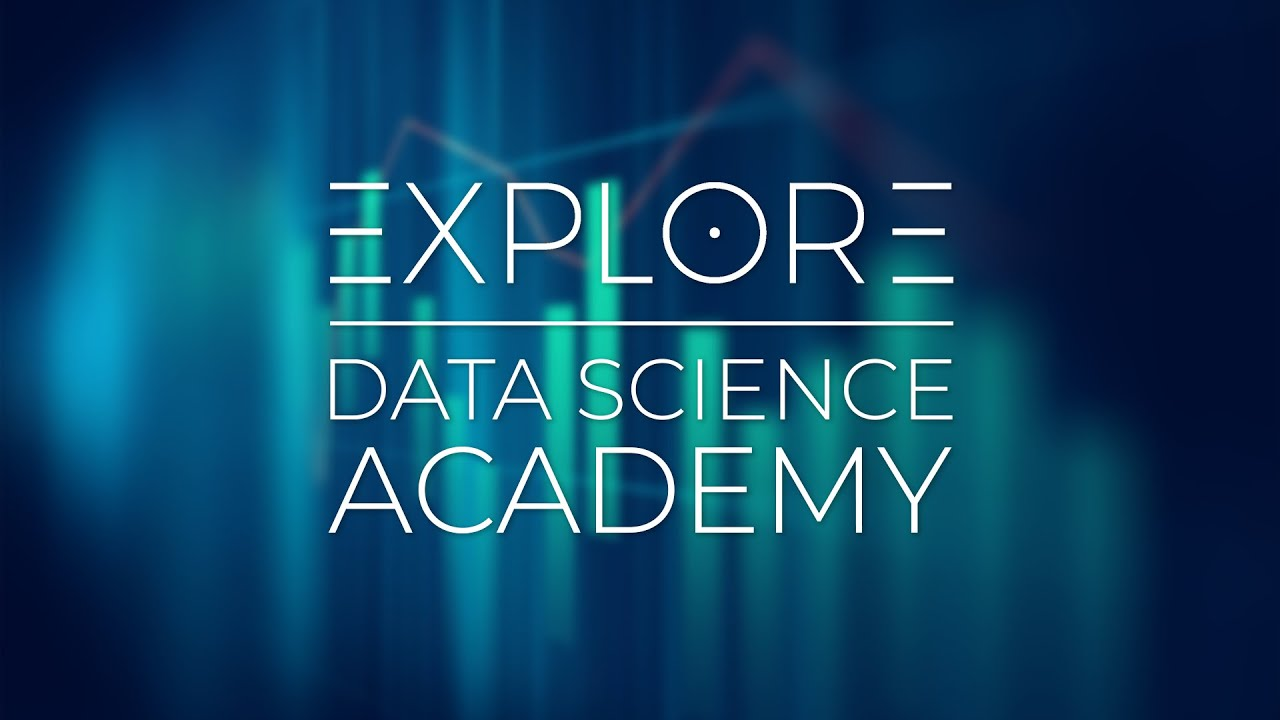


## 1. Importing Packages


In [33]:
import nltk
from nltk.corpus import stopwords
from sklearn.utils import resample
import re
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
import pandas as pd

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Customise our plotting settings
rcParams['figure.figsize'] = 10, 5
sns.set_style('whitegrid')

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

# set plot style
sns.set()




## 2. Loading Data


We first load the data and inspect its head.

In [125]:
# Loading the test data set.
Test = pd.read_csv('test_with_no_labels.csv')

# Loading the Train data set.
Train = pd.read_csv('train.csv')

In [5]:
Test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [6]:
Train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954



## 3. Exploratory Data Analysis (EDA)


In this section we perform exploratory data analysis on the data to gain a better understanding of the features and the relationships between them. We will employ both statistical and visualisation methods of EDA.

## DATA CLEANING

### Dropping the tweetid column

In [126]:
Train = Train.drop('tweetid', axis=1)
#Test = Test.drop('tweetid', axis=1)



In [31]:
Train.shape

(15819, 2)

In [29]:
print(list(Train['sentiment'].unique()))

[1, 2, 0, -1]


Let's have a look at how many data samples we have for each of the different sentiments.

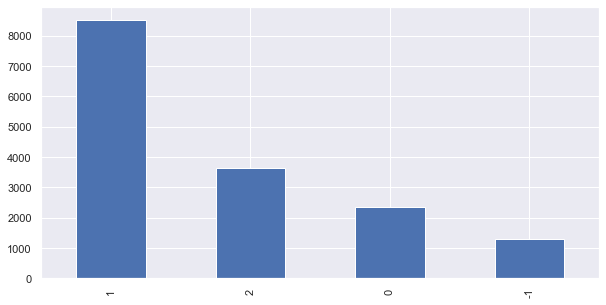

In [73]:
Train['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

## Dealing with class imbalance 

In [133]:
# We first vectorize the data
vect = CountVectorizer(lowercase=True, stop_words='english', max_features=100,analyzer='word', ngram_range=(1, 3))
X_tr = vect.fit_transform(Train['message'].values.astype(str))
X_ts = vect.fit_transform(Test['message'].values.astype(str))
X_tr = X_tr.toarray()
X_ts = X_ts.toarray()
y = Train['sentiment']
y = y.to_numpy()

In [134]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Fit label encoder and return encoded labels
y = le.fit_transform(Train['sentiment'])
y

array([2, 2, 3, ..., 1, 0, 1], dtype=int64)

In [135]:
type_labels = list(le.classes_)
type_labels

[-1, 0, 1, 2]

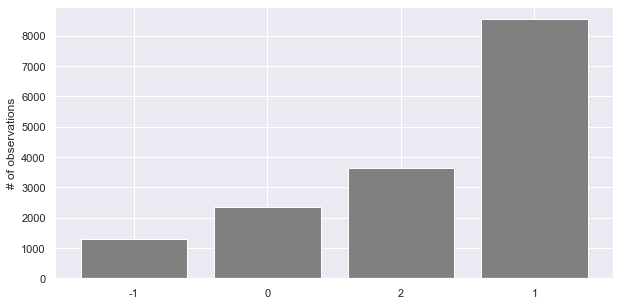

In [136]:
# Let's first have a look at the current distribution of classes again:
heights = [len(y[y == label]) for label in range(len(type_labels))]
bars = pd.DataFrame(zip(heights,le.transform(type_labels).T, type_labels), columns=['heights','labels','names'])
bars = bars.sort_values(by='heights',ascending=True)

plt.bar(range(len(bars)),bars['heights'],color='grey')
plt.xticks(range(len(bars)),bars['names'])
plt.ylabel("# of observations")
plt.show()

In [137]:
# Let's pick a class size of roughly half the size of the largest size
class_size = 4250

In [139]:
# Before resampling, let's stitch our features and labels together
data = np.concatenate([X_tr, y[:,np.newaxis]], axis=1)
bar_label_df = bars.set_index('labels')

In [140]:
bar_label_df

,heights,names
labels,,
0,1296,-1
1,2353,0
3,3640,2
2,8530,1


In [142]:
resampled_classes = []

# For each label
for label in range(len(type_labels)):
    # Get num. of observations from this class
    label_size = bar_label_df.loc[label]['heights']
    
    # If label_size < class size the upsample, else downsample
    if label_size < class_size:
        # Upsample
        label_data = data[data[:,-1] == label]
        label_resampled = resample(label_data,
                                  replace=True, # sample with replacement (we need to duplicate observations)
                                  n_samples=class_size, # number of desired samples
                                  random_state=27) # reproducible results
    else:
        # Downsample
        label_data = data[data[:,-1] == label]
        label_resampled = resample(label_data,
                                  replace=False, # sample without replacement (no need for duplicate observations)
                                  n_samples=class_size, # number of desired samples
                                  random_state=27) # reproducible results
        
    resampled_classes.append(label_resampled)

In [143]:
resampled_data = np.concatenate(resampled_classes, axis=0)

In [144]:
resampled_data.shape

(17000, 101)

In [145]:
#Split resampled data into X and y
X_resampled = resampled_data[:,:-1]
y_resampled = resampled_data[:,-1]

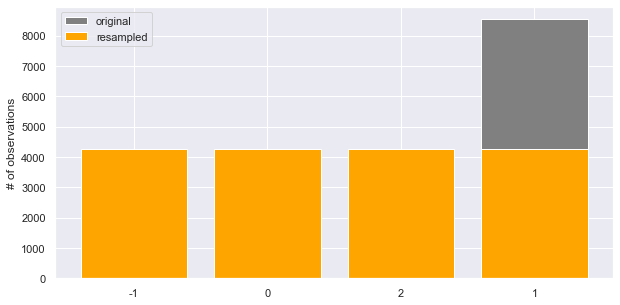

In [146]:
#Now let's view the after image:
heights = [len(y_resampled[y_resampled == label]) for label in range(len(type_labels))]
bars_resampled = pd.DataFrame(zip(heights,le.transform(type_labels).T, type_labels), columns=['heights','labels','names'])
bars_resampled = bars_resampled.sort_values(by='heights',ascending=True)

plt.bar(range(len(bars)),bars['heights'],color='grey')
plt.bar(range(len(bars_resampled)),bars_resampled['heights'],color='orange')
plt.xticks(range(len(bars)),bars['names'])
plt.ylabel("# of observations")
plt.legend(['original','resampled'])
plt.show()

In [147]:
# Setting up the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=27)

In [148]:
# Training the logistic regression model on our rebalanced data
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train, y_train)

C:\Users\Hudson\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='ovr')

In [149]:
# Generate predictions
y_pred_test = logreg.predict(X_test)

In [150]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.54      0.42      0.47       847
           1       0.48      0.53      0.51       877
           2       0.56      0.40      0.47       844
           3       0.58      0.81      0.68       832

    accuracy                           0.54      3400
   macro avg       0.54      0.54      0.53      3400
weighted avg       0.54      0.54      0.53      3400



In [151]:
# Use the model on the test set without labels
predictions = logreg.predict(X_ts)

In [152]:
predictions.shape

(10546,)

In [153]:
Test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [154]:
df_tid = pd.DataFrame(Test.tweetid)
df_tid.head()

,tweetid
0,169760
1,35326
2,224985
3,476263
4,872928


In [155]:
df_test_pred = pd.DataFrame(predictions,columns=['sentiment'])
df_test_pred.head()

,sentiment
0,2
1,1
2,1
3,2
4,2


In [156]:
sub = pd.concat([df_tid,df_test_pred], axis = 1)
sub

,tweetid,sentiment
0,169760,2
1,35326,1
2,224985,1
3,476263,2
4,872928,2
...,...,...
10541,895714,2
10542,875167,1
10543,78329,2
10544,867455,2


In [157]:
sub.to_csv('./submission.csv',index=False)